In [1]:


from CombinedExperiment import CombinedExperiment
from ExperimentConfig import ExperimentConfig
from Experiment import Experiment, RaceResult
from util.snap import snap
from copy import copy
from typing import List
from elections.Candidate import Candidate
from elections.Voter import Voter
from elections.ElectionResult import ElectionResult
from elections.DefaultConfigOptions import unit_election_config
from elections.Ballot import Ballot

from joblib import Parallel, delayed
from CombinedExperiment import ExperimentResult
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "5"

version = "v18"
base_config = ExperimentConfig(name="none",
                               election_name="none",
                               training_cycles=200000,
                               ideology_range=1.5,
                               ideology_flexibility=.7,
                               n_bins=21,
                               model_width=512,
                               model_layers=3,
                               memory_size=100000,
                               batch_size=2048,
                               training_voters=400,
                               sampling_voters=10000,
                               quality_variance=0,
                               candidate_variance=0.5,
                               equal_pct_bins=True,
                               model_path="none")

irv_a_config = copy(base_config)
irv_a_config.election_name = "IRV"
irv_a_config.model_path = f"exp/{version}/IRV-A"
irv_a_config.name = "IRV"

h2h_a_config = copy(base_config)
h2h_a_config.election_name = "H2H"
h2h_a_config.model_path = f"exp/{version}/H2H-A"
h2h_a_config.name = "Condorcet-Minimax"

irv_b_config = copy(base_config)
irv_b_config.election_name = "IRV"
irv_b_config.model_path = f"exp/{version}/IRV-B"
irv_b_config.name = "IRV"

h2h_b_config = copy(base_config)
h2h_b_config.election_name = "H2H"
h2h_b_config.model_path = f"exp/{version}/H2H-B"
h2h_b_config.name = "Condorcet-Minimax"


def run_election(self,
                 candidates: List[Candidate],
                 voters: List[Voter]) -> ElectionResult:
    ballots = [Ballot(v, candidates, unit_election_config) for v in voters]
    process = self.config.election_constructor()
    result = process.run(ballots, set(candidates))
    return result


class RandomCandidateFactory:
    def candidates(self, n):
        cc = ExperimentConfig("none", "none")
        return cc.gen_random_candidates(n)

class BetterCandidateFactory:
    def candidates(self, n):
        cc = ExperimentConfig("none", "none")
        return cc.gen_candidates(n)

class CCResult:
    def __init__(self, irv_sr: RaceResult, h2h_sr: RaceResult):

        self.irv_sr = irv_sr
        self.h2h_sr = h2h_sr

def run_one_comparison(candidate_factory, irv_config: ExperimentConfig, h2h_config: ExperimentConfig, n_voters: int) -> CCResult:
    irv_exp = Experiment(irv_config)
    h2h_exp = Experiment(h2h_config)
    irv_exp.config.sampling_voters = n_voters
    h2h_exp.config.sampling_voters = n_voters
    candidates = candidate_factory.candidates(5)

    irv_sr = irv_exp.run_strategic_race_c(candidates)
    h2h_sr = h2h_exp.run_strategic_race_c(candidates)

    return CCResult(irv_sr, h2h_sr)

def compare_methods(candidate_factory, i_config: ExperimentConfig, h_config: ExperimentConfig, n_voters: int, n_races: int) -> List[ElectionResult]:
    # results = [run_one_comparison(candidate_factory, i_config, h_config, n_voters) for _ in range(n_races)]
    results: List[CCResult] = Parallel(n_jobs=32)(
        delayed(run_one_comparison)(candidate_factory, i_config, h_config, n_voters) for _ in range(n_races))
    return results

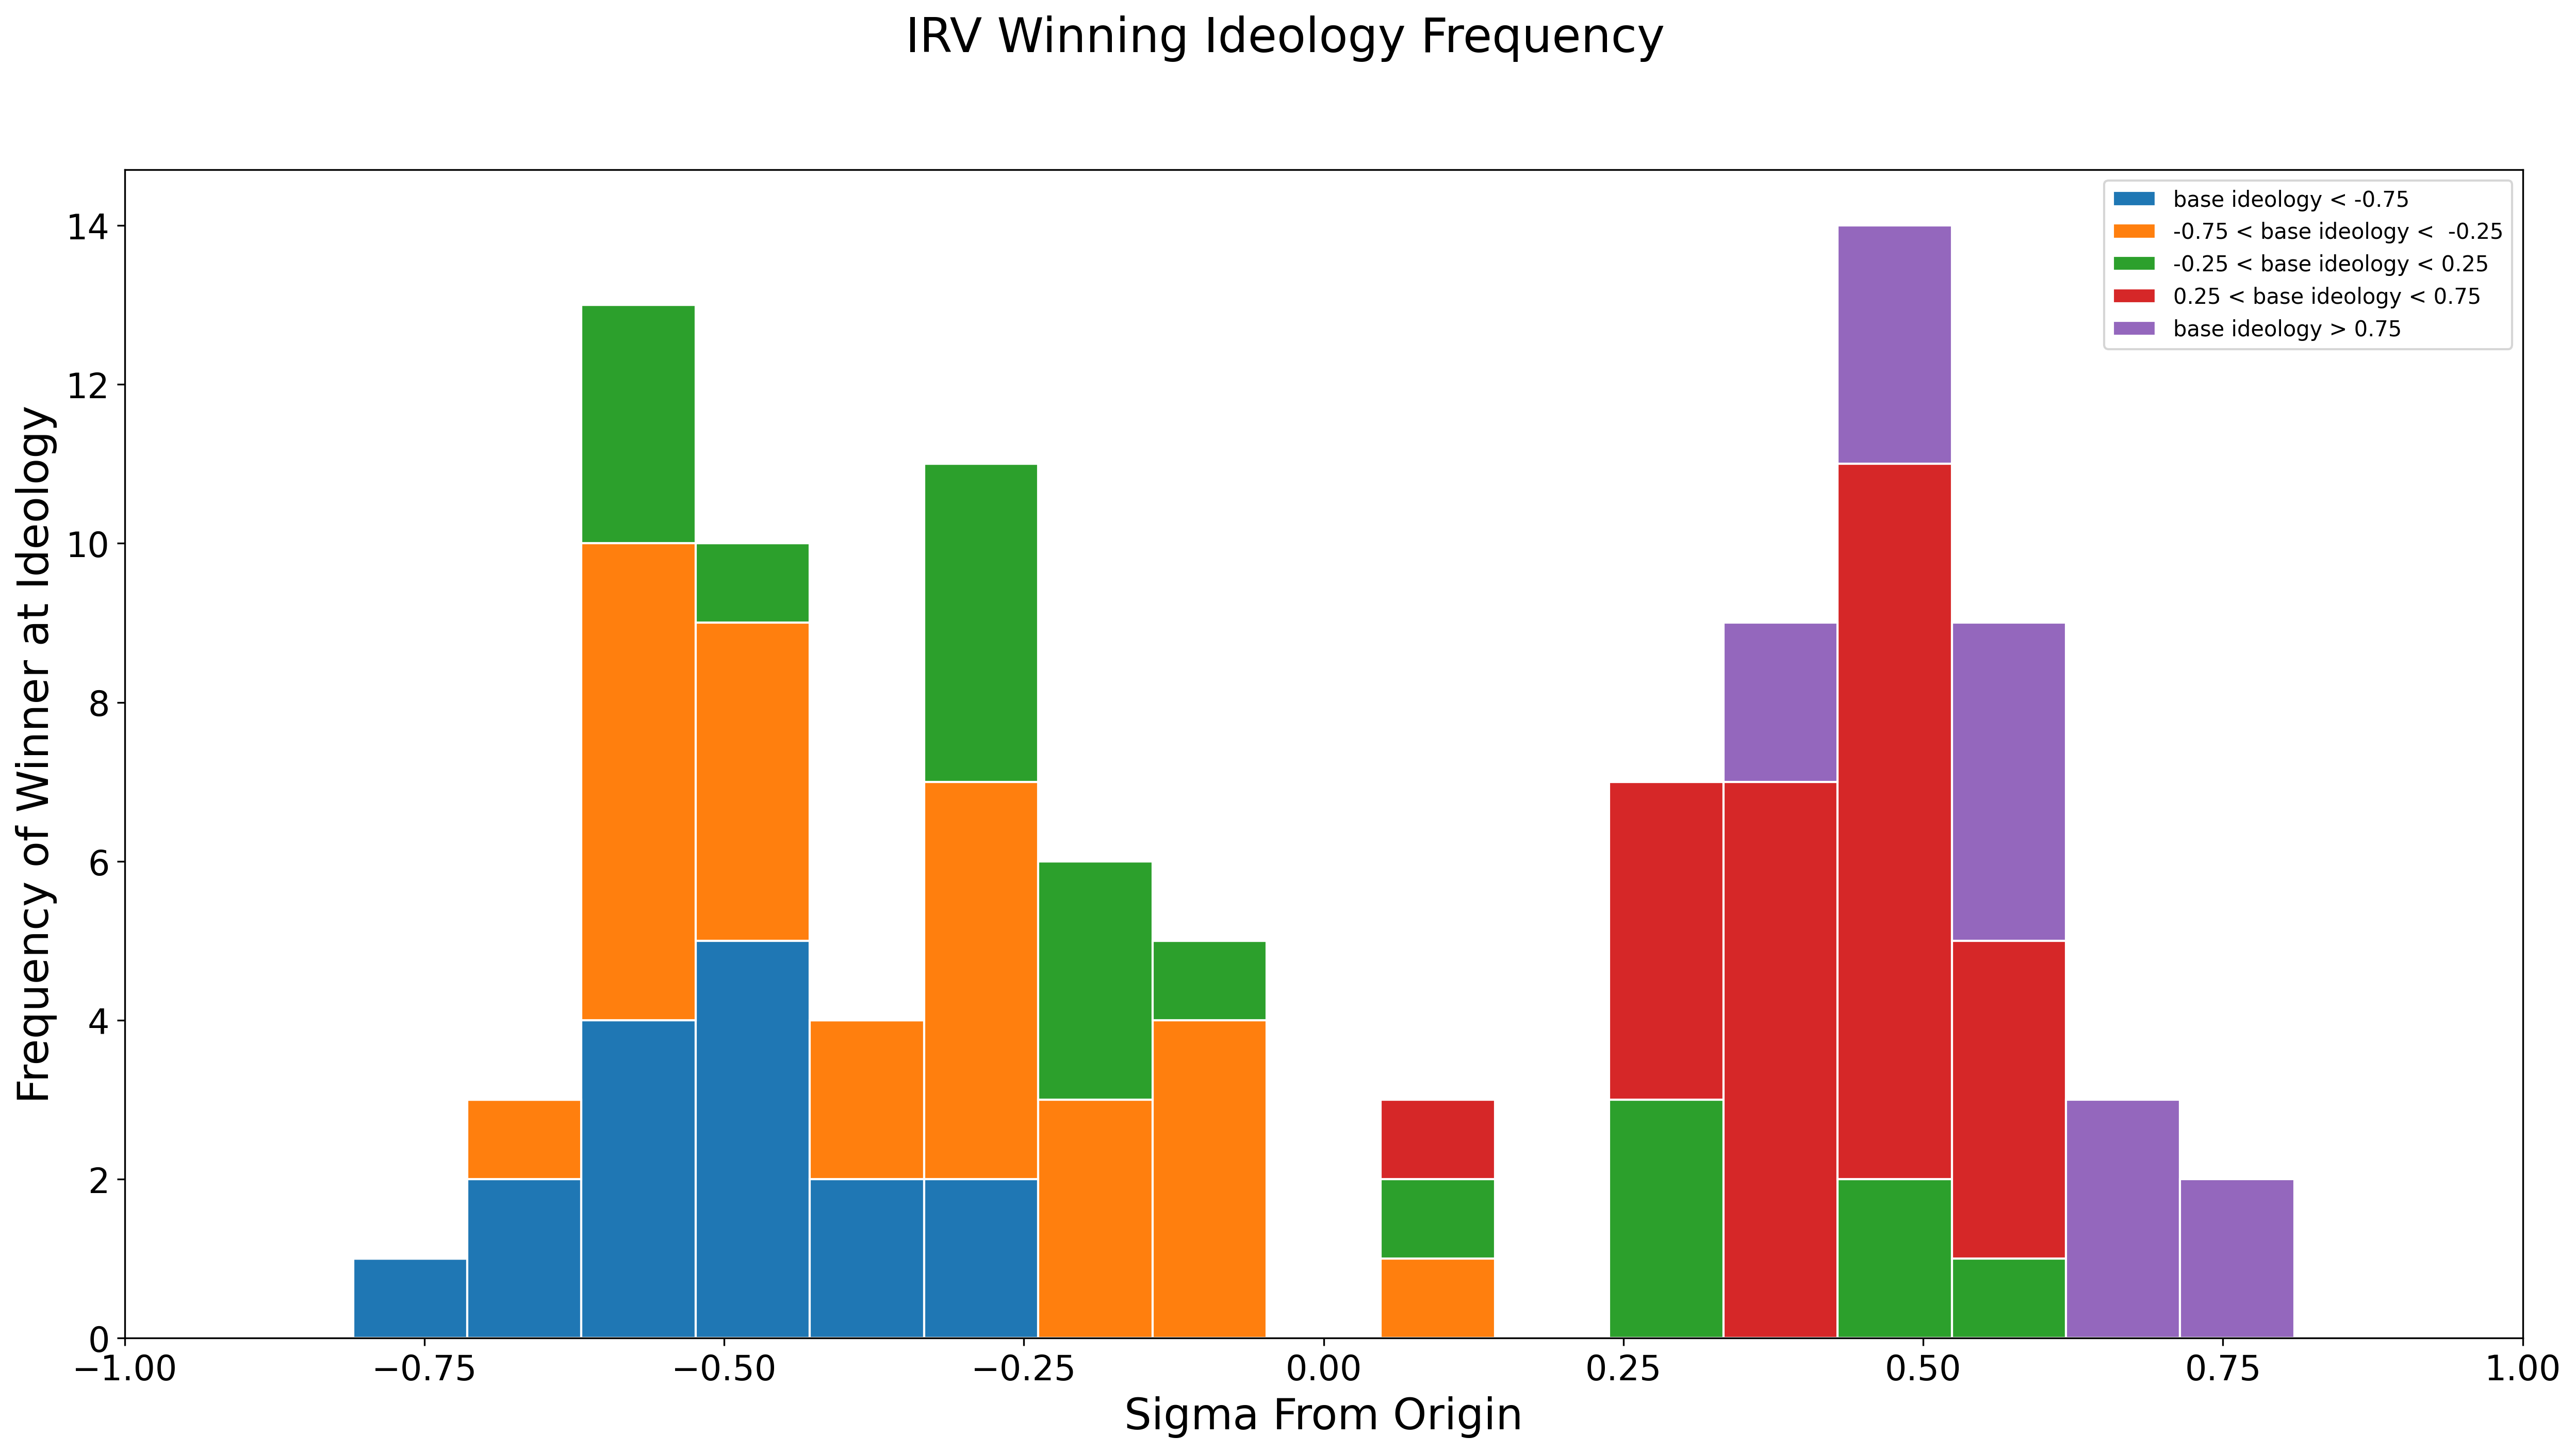

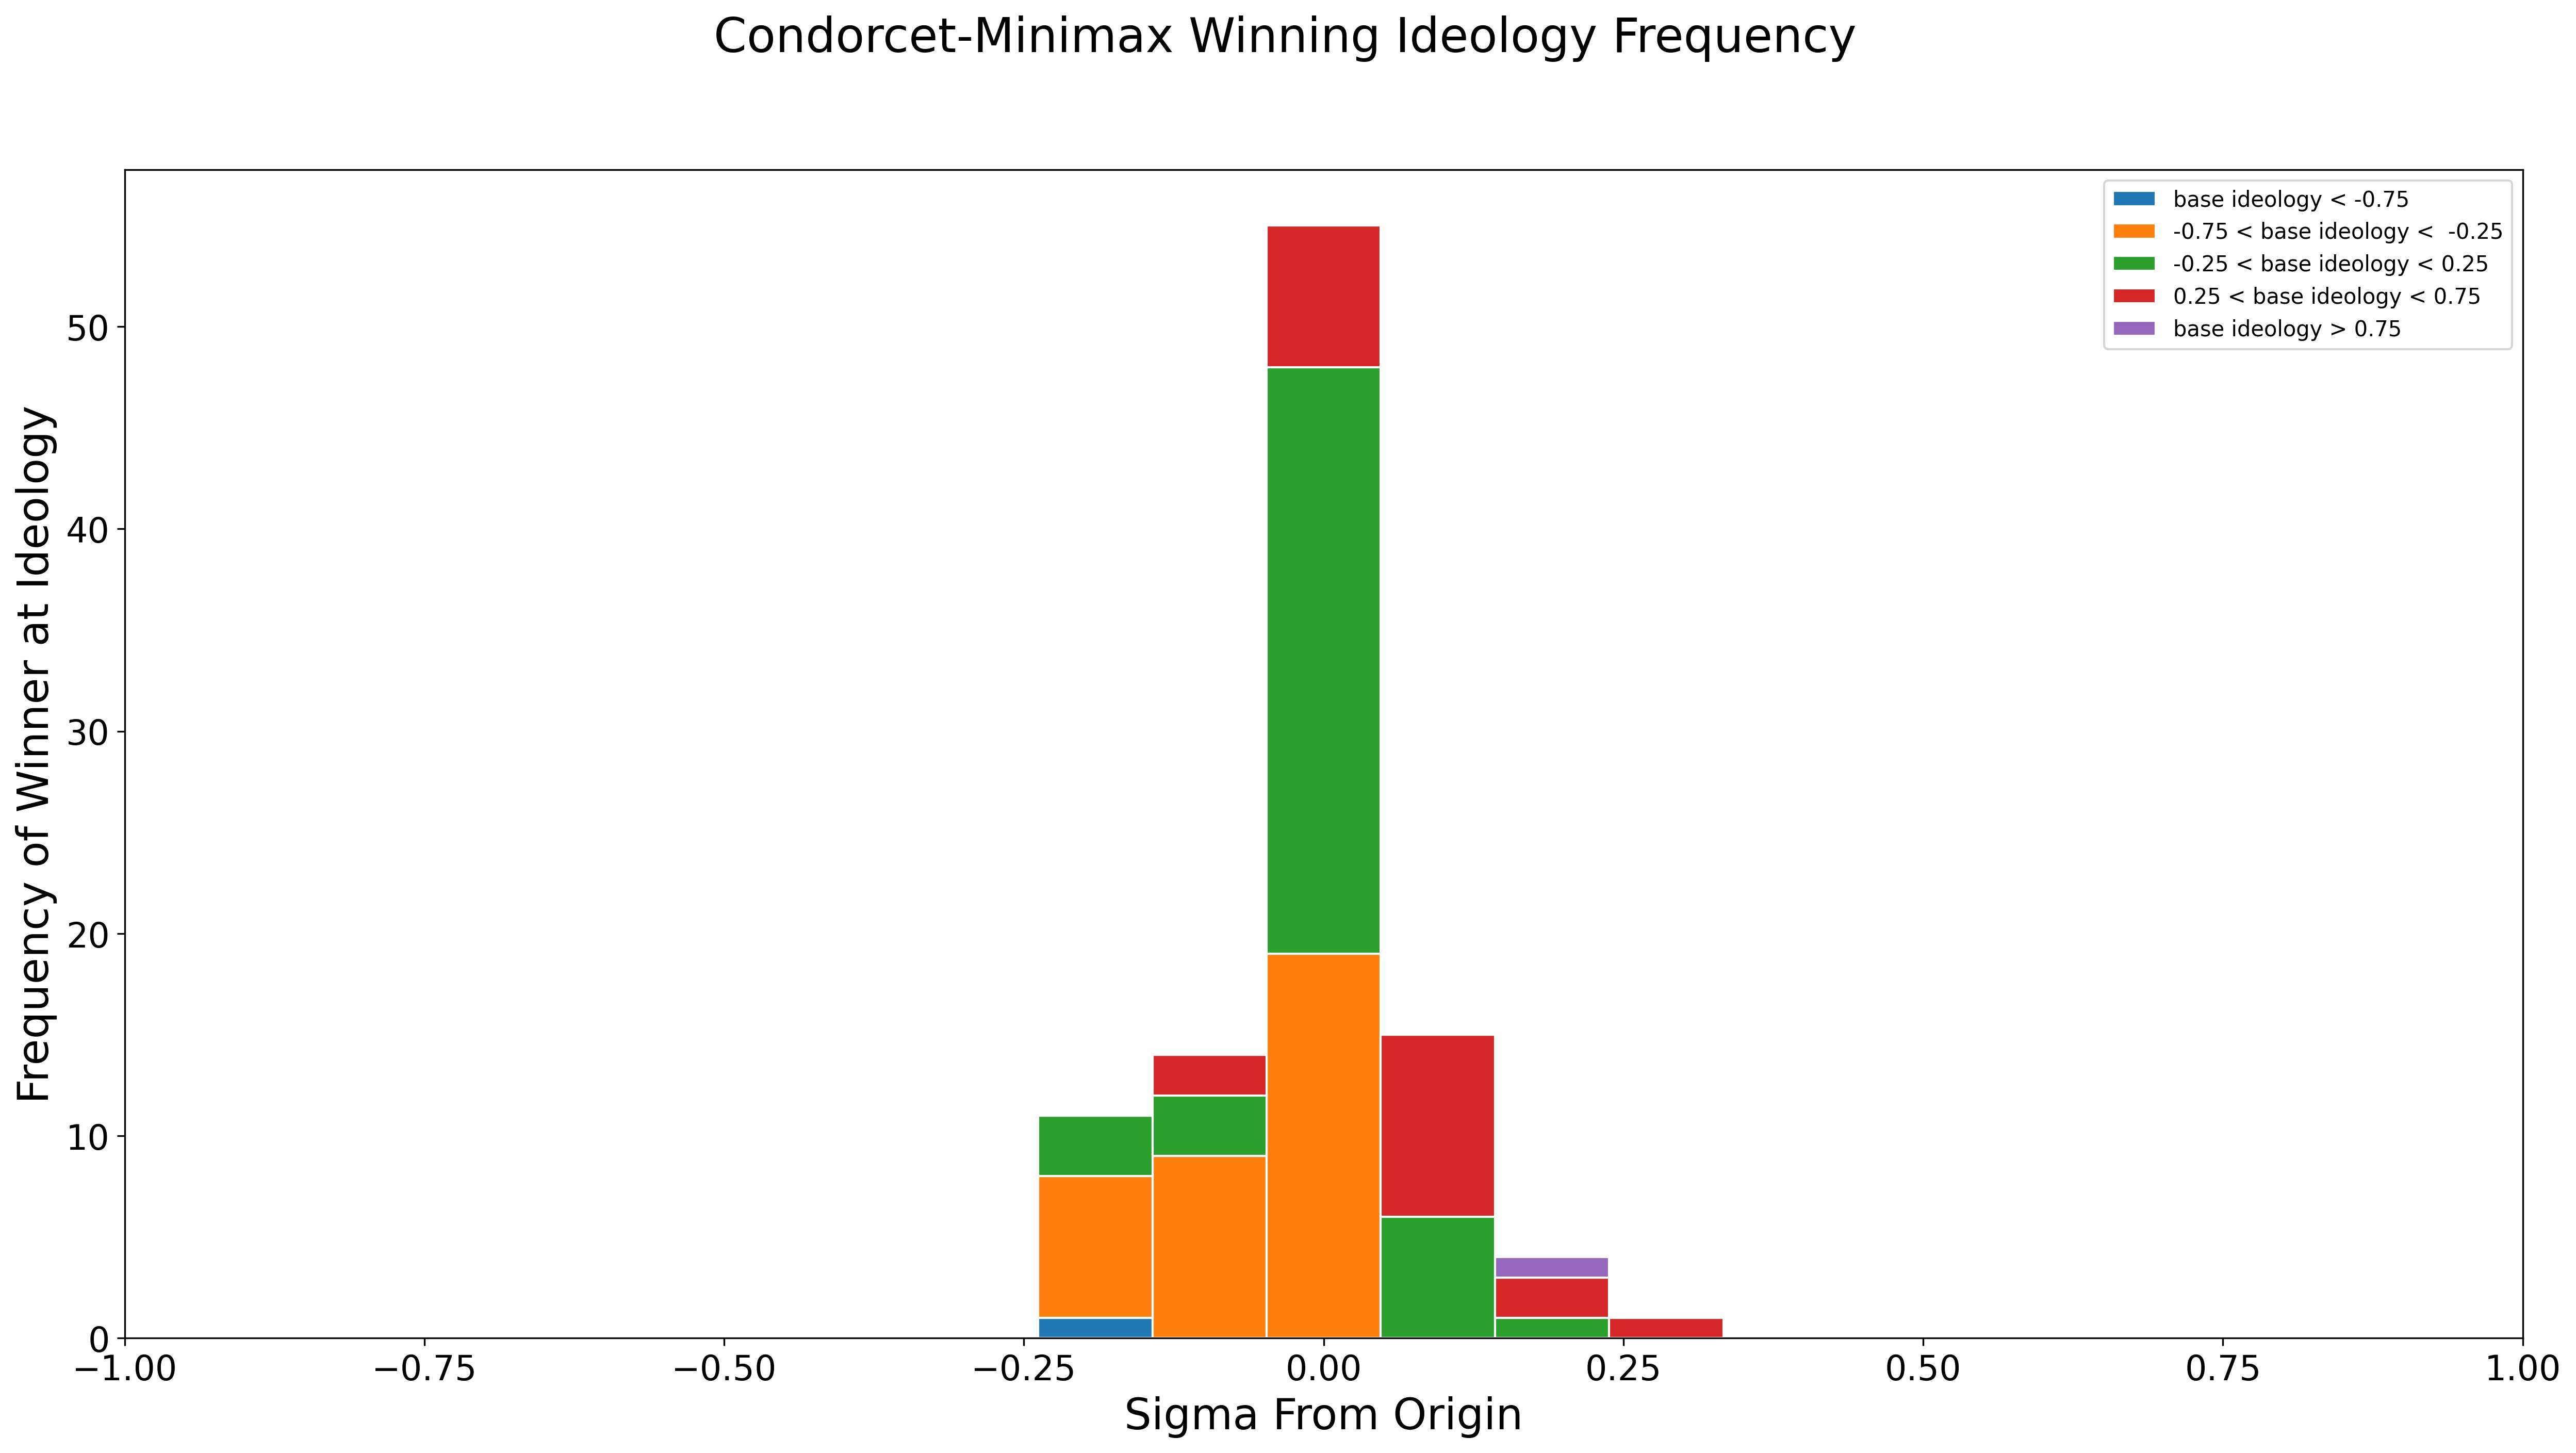

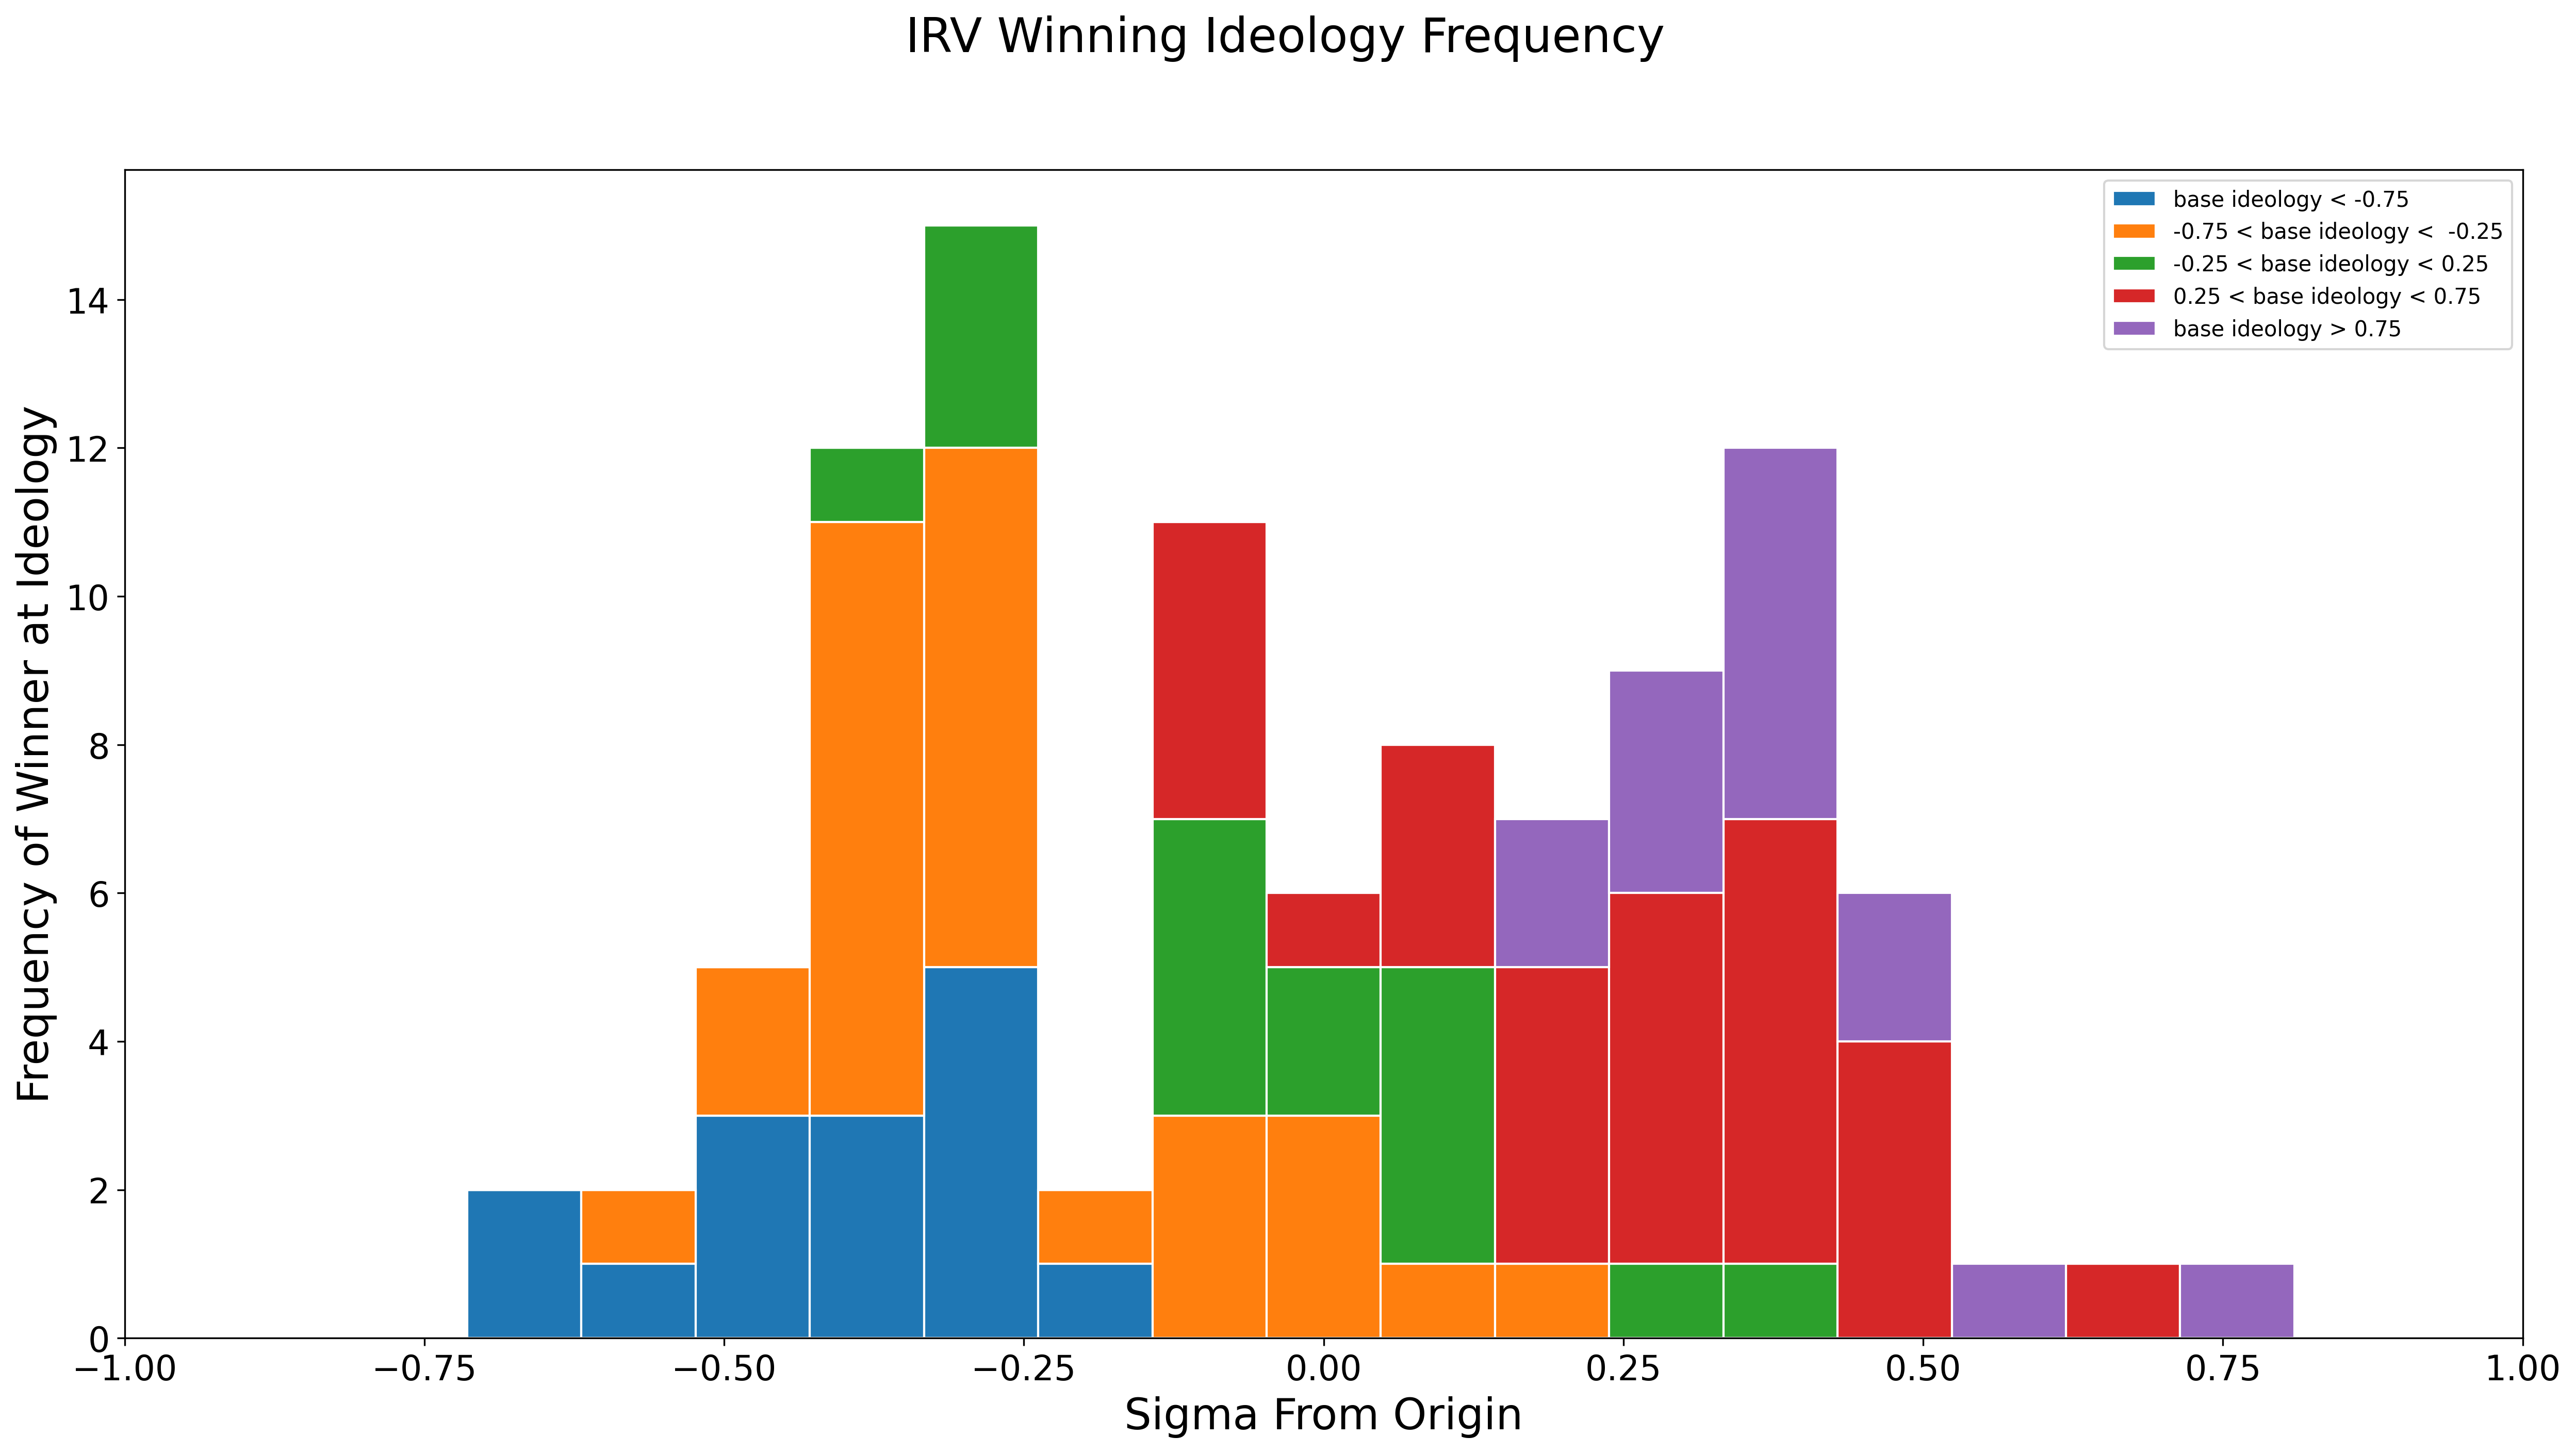

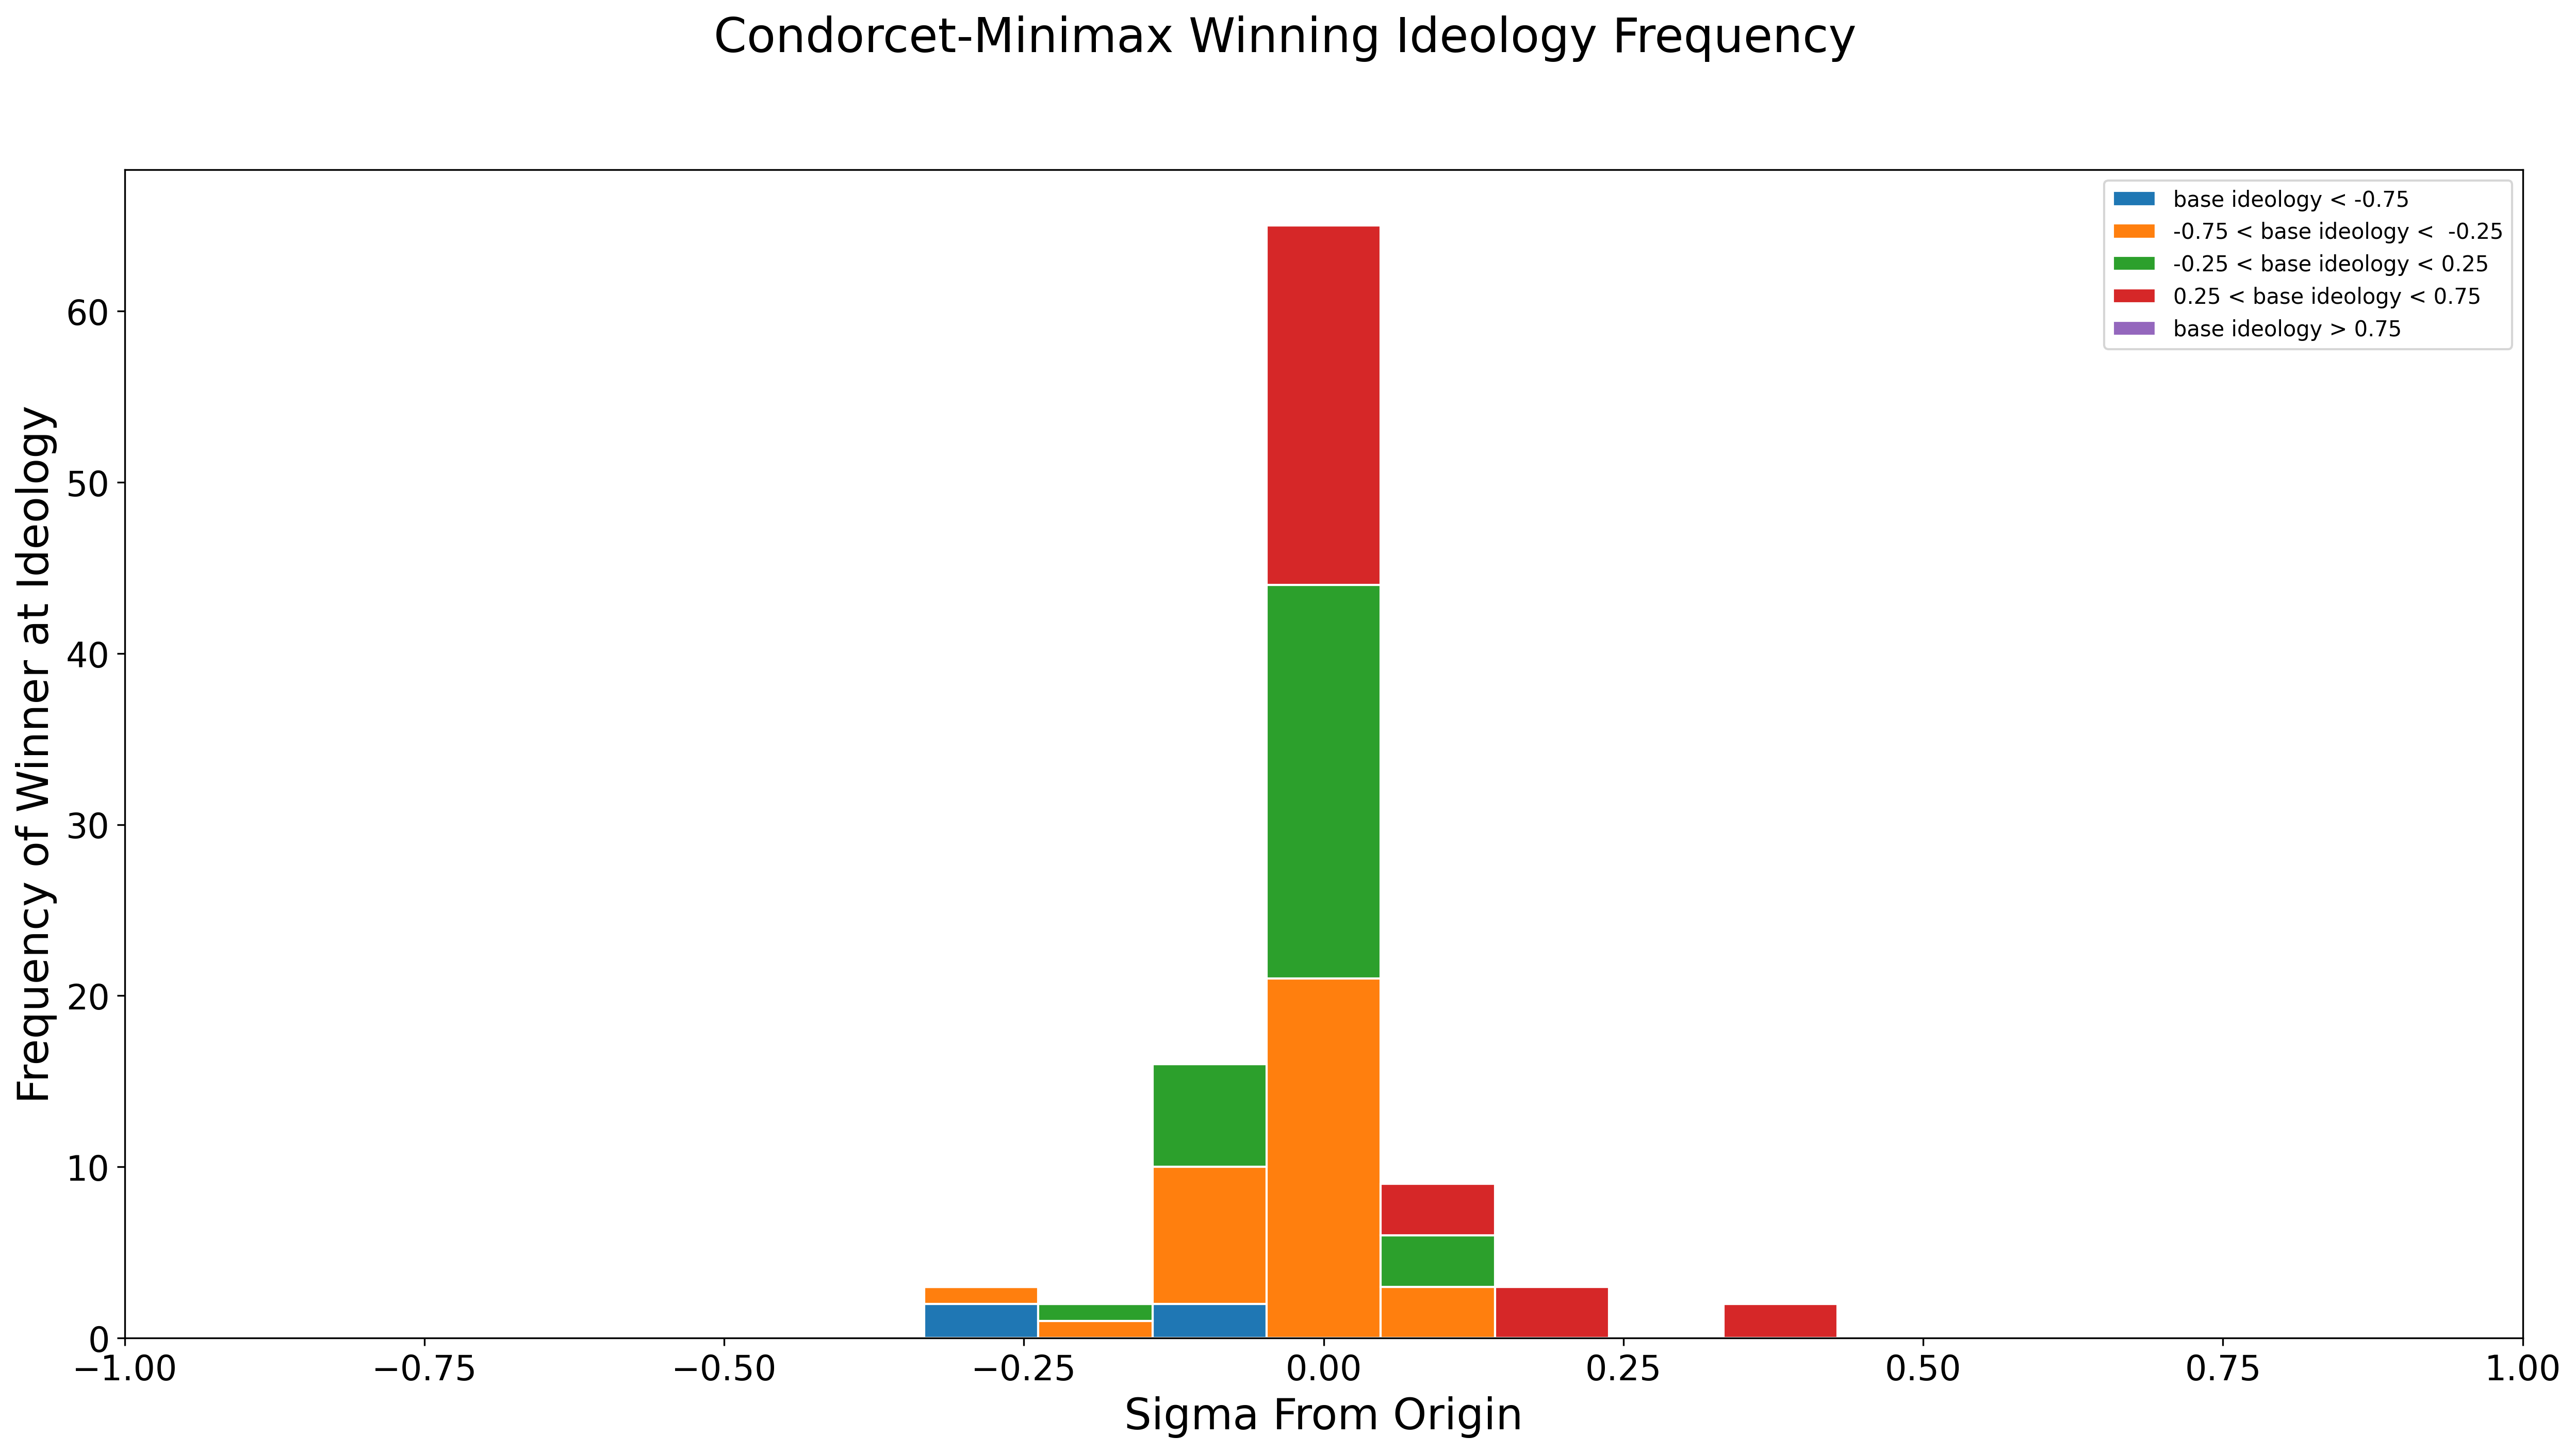

In [2]:
def split_by_bin(data: List[float], split_data: List[float], ordered_bins: List[float]) -> List[List[float]]:
    results = [[] for _ in ordered_bins]

    for i in range(len(data)):
        bin = len(ordered_bins) - 1
        while split_data[i] < ordered_bins[bin]:
            bin -= 1
            if bin < 0:
                print("bin is less than zero!  %.3f" % split_data[i])
        results[bin].append(data[i])
    return results


def plot_winners(i_config: ExperimentConfig, h_config: ExperimentConfig):
    bins = [-1000, -.75, -0.25, .25, .75]
    labels = ["base ideology < -0.75",
              "-0.75 < base ideology <  -0.25",
              "-0.25 < base ideology < 0.25",
              "0.25 < base ideology < 0.75",
              "base ideology > 0.75"]

    n_voters = 1000
    n_races = 100
    results = compare_methods(BetterCandidateFactory(), i_config, h_config, n_voters, n_races)

    exp = Experiment(i_config)

    irv_winning_ideology = [cc.irv_sr.winner.ideology.vec[0] for cc in results]
    irv_winning_base_ideology = [cc.irv_sr.winner_base.ideology.vec[0] for cc in results]
    plot_data = split_by_bin(irv_winning_ideology, irv_winning_base_ideology, bins)
    exp.plot_results(plot_data, "IRV Winning Ideology Frequency", labels)

    h2h_winning_ideology = [cc.h2h_sr.winner.ideology.vec[0] for cc in results]
    h2h_winning_base_ideology = [cc.h2h_sr.winner_base.ideology.vec[0] for cc in results]
    plot_data = split_by_bin(h2h_winning_ideology, h2h_winning_base_ideology, bins)
    exp.plot_results(plot_data, "Condorcet-Minimax Winning Ideology Frequency", labels)


plot_winners(irv_a_config, h2h_a_config)
plot_winners(irv_b_config, h2h_b_config)